In [66]:
# 添加库函数
import os
import torch
import torch.nn as nn
import math
import torch.optim as optim
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,OrthographicCameras
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
from torch.autograd import gradcheck

import plotly.graph_objects as go

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(90, 90)
    ax.axis('equal')
    plt.show()

def plot_pointclouds_rotation(mesh, title = ""):
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    # 创建 3D 图形
    fig = go.Figure(data=[go.Scatter3d(
        x=x, 
        y=y, 
        z=z, 
        mode='markers',
        marker=dict(
            size=2  # 设置点的大小
        )
    )])

    # 更新布局
    fig.update_layout(scene=dict(
        xaxis_title='X label',
        yaxis_title='Y label',
        zaxis_title='Z label'                                                                                                               
    ))

    # 显示图形
    fig.show()
    # 将图形保存为html文件
    fig.write_html(title+".html")

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [67]:
# 载入一个模型
# trg_obj = 'Geographos Radar-based, low-res(1).obj'
# trg_obj = 'Castalia Radar-based.obj'
# trg_obj = 'Toutatis Radar-based.obj'
trg_obj = 'wx_origin.obj'

# trg_obj = 'dolphin.obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
# # 平均直径
mean_diameter = 2.56e3
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
# 将模型绕X轴旋转90度
R = torch.tensor([[1, 0, 0],
                  [0, 0, -1],
                  [0, 1, 0]], dtype=torch.float32).to(device)
verts = verts @ R
# 将模型绕Y轴旋转90度
R = torch.tensor([[0, 0, 1],
                  [0, 1, 0],
                  [-1, 0, 0]], dtype=torch.float32).to(device)
verts = verts @ R
# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])


# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures
src_mesh = trg_mesh

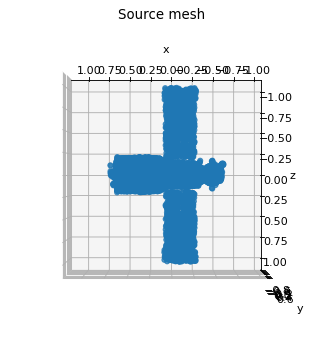

In [68]:
# # 创建初始模型，球形
# sphere1 = ico_sphere(4, device)
# sphere2 = ico_sphere(4, device)

# # 平移第二个球体，使它与第一个球体黏连
# # 获取第一个球体的最大 x 坐标
# max_x = sphere1.verts_packed()[:, 0].max()

# # 获取第二个球体的顶点并进行x方向平移
# shift = max_x - 0.1  # 确保轻微重叠
# verts2 = sphere2.verts_packed() + torch.tensor([shift, 0, 0], device=device)

# # 获取第一个球体的顶点并且平移
# verts1 = sphere2.verts_packed() + torch.tensor([-shift, 0, 0], device=device)

# # 合并两球体的顶点
# verts = torch.cat([verts1, verts2], dim=0)

# # 将两球质点平移
# # verts = verts + torch.tensor([0, 0, 0.8], device=device)

# # 合并面片，并更新第二个球体的面片索引
# faces1 = sphere1.faces_packed()
# faces2 = sphere2.faces_packed() + sphere1.verts_packed().shape[0]  # 更新索引

# # 合并面片数据
# faces = torch.cat([faces1, faces2], dim=0)

# # 将模型绕Y轴旋转90度
# R = torch.tensor([[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [-1.0, 0.0, 0.0]], device=device)
# verts = verts @ R


# # 创建黏连的球体网格
# src_mesh = Meshes(verts=[verts], faces=[faces])


# verts = src_mesh.verts_packed()
# faces = src_mesh.faces_packed()
# scaled_verts = verts * 0.5

# src_mesh = Meshes(verts=[scaled_verts], faces=[faces])

# 绘制初始情况下的src_mesh
plot_pointcloud(src_mesh, "Source mesh")
trg_mesh = src_mesh

In [69]:
# 输入大小为[1,3]初始向量vec，大小分别为[1]旋转轴axis_x,axis_y,axis_z，大小为[num,1]的旋转角度theta，输出大小为[num,3]的旋转后向量
def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot


In [70]:
# 制造可视化模型
class visible_mesh(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device

    def forward(self,mesh,RadarLos):
        batch = RadarLos.shape[0]
        face_num = mesh.faces_packed().shape[0]
        face_mask = torch.zeros((batch,face_num),dtype=bool,device=self.device)
        # 计算由函数look_at_view_transform得到的旋转矩阵和平移矩阵
        at = torch.tensor([0.0, 0.0, 0.0], device=device).expand(RadarLos.shape)
        up = torch.tensor([0.0, 1.0, 0.0], device=device).expand(RadarLos.shape)

        R, T = look_at_view_transform(eye=RadarLos*3, at=at, up=up)
        # 生成渲染器
        raster_settings = RasterizationSettings(
            image_size=1024, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
        )
        # 生成相机
        cameras = OrthographicCameras(device=self.device, R=R, T=T)
        # 生成栅格化器
        rasterizer = MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        )
        fragments = rasterizer(mesh.extend(batch))
        # 在并行处理时，一个batch中的不同mesh有不同的面标识，但这些面标识有规律的从小到大排列,因此可以直接Unique
        p2f = fragments.pix_to_face
        p2f_mask = p2f[p2f>=0]
        p2f_mask_unique = torch.unique(p2f_mask)
        face_mask = face_mask.view(-1)
        face_mask[p2f_mask_unique] = True
        face_mask = face_mask.view(batch,-1)

        all_faces = mesh.faces_packed()
        all_verts = mesh.verts_packed() 
        # 利用面掩码生成批次索引
        batch_size, num_faces = face_mask.shape
        faces_batch = [all_faces[m] for m in face_mask]
        verts_batch = [all_verts] * batch_size  # 假设每个 batch 使用同样的顶点
        # 直接创建 Meshes 对象
        Meshes_new = Meshes(verts=verts_batch, faces=faces_batch)
        # plot_pointcloud(Meshes_new[0], "Visible mesh")

        return Meshes_new
    



In [71]:
# 获得相机位置和视线位置对应的旋转矩阵

def get_normals(meshes):
    verts_packed = meshes.verts_packed()  # (V, 3)
    faces_packed = meshes.faces_packed()  # (F, 3)

    # 获取每个面的顶点
    faces_verts = verts_packed[faces_packed]  # (F, 3, 3)

    # 计算叉乘，获取法向量
    face_normals = torch.cross(
        faces_verts[:, 1] - faces_verts[:, 0],
        faces_verts[:, 2] - faces_verts[:, 0],
        dim=1
    )

    # 归一化法向量
    face_normals = face_normals / (face_normals.norm(dim=1, keepdim=True) + 1e-6)

    # face_normals 现在是每个面的法向量
    return face_normals

def rr2rd(meshes, doppler_vec, dopplercoefficient):
    verts_list = meshes.verts_list()
    faces_list = meshes.faces_list()
    # 将dopplercorfficient转换为list
    dopplercoefficient = dopplercoefficient.tolist()

    # 确保 doppler_vec 的长度等于 verts_list 的长度
    if len(doppler_vec) != len(verts_list):
        raise ValueError("Length of doppler_vec must match number of vertex lists")
    # print(doppler_vec)
    # print(verts_list.shape)
    projection_list = [
        (verts @ doppler_vec[i].unsqueeze(1)) * doppler_vec[i].unsqueeze(1).T
        for i, verts in enumerate(verts_list)
    ]
    
    scaled_projection = [proj * coefficient for proj,coefficient in zip(projection_list,dopplercoefficient)]
    scaled_verts_list = [verts + (scaled - proj) for verts, scaled, proj in zip(verts_list, scaled_projection, projection_list)]

    # 创建新的 Meshes 对象
    meshes_scaled = Meshes(verts=scaled_verts_list, faces=faces_list)

    return meshes_scaled

def angel2vec(ele,azi):
    elev_rad = torch.deg2rad(ele)
    azim_rad = torch.deg2rad(azi)
    
    direction_vector = torch.stack([
        torch.cos(elev_rad) * torch.sin(azim_rad),
        torch.sin(elev_rad),
        torch.cos(elev_rad) * torch.cos(azim_rad)
    ],dim=-1)

    return direction_vector

class mesh_radar_render(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device
    
    def forward(self,meshes,radarlos,omega_vec,omega,dopplercoefficient):

        # 输入为 mesh [batch]
        # radarlos [batch,3]
        # omega_vec [batch,3]
        # omega [batch]
        # dopplercoefficient [batch]
        # 输出为 image [batch,100,100]

        # from opts import config_parser
        # parser = config_parser()
        # args = parser.parse_args()

        # 多普勒轴
        doppler_vec = torch.linalg.cross(radarlos,omega_vec)
        # 对doppler_vec进行归一化
        doppler_vec = doppler_vec / (torch.linalg.norm(doppler_vec,dim=-1).unsqueeze(-1) + 1e-6)
        # 生成成像方向
        image_vec = torch.linalg.cross(radarlos,doppler_vec)
        # 计算由函数look_at_view_transform得到的旋转矩阵和平移矩阵
        at = torch.tensor([0.0, 0.0, 0.0], device=device).expand(radarlos.shape)

        R, T = look_at_view_transform(eye=image_vec*3*mean_diameter, at=at, up=radarlos)
        cameras = OrthographicCameras(device=device, R=R, T=T)
        # 获得法向量
        normals = get_normals(meshes)
        # 对mesh进行变换到多普勒域
        meshes_scaled = rr2rd(meshes,doppler_vec,dopplercoefficient)
        # 渲染
        raster_settings = RasterizationSettings(
            image_size=(100,100), 
            blur_radius=0, 
            faces_per_pixel=3,
        )
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )
        fragments = rasterizer(meshes_scaled)
        # print(fragments.pix_to_face.shape)
        # print(fragments.pix_to_face[0,50,:,:])
        image_temp = torch.sum(fragments.pix_to_face[0,:,:,:],dim=-1)
        image_temp = torch.rot90(image_temp,k=1,dims=(0,1))
        # plt.imshow(image_temp.detach().cpu().numpy())
        # # 将生成图片不带坐标轴的保存
        # plt.axis('off')
        # plt.savefig('image_temp.png',bbox_inches='tight',pad_inches=0)
        # plt.close()
        # 计算法向量，并消除不合法的索引和负值
        zero_vector = torch.zeros(1, 3, device=self.device)
        normal_batch = torch.where(
            fragments.pix_to_face[...,None] == -1,                      # 添加维度适配零向量
            zero_vector,                               # 用零向量替换不合法的索引
            normals[fragments.pix_to_face.clamp_min(0)]                  # 使用 torch.clamp_min 防止负值索引
        )
        # # 计算每一点沿视线方向到原点的距离
        # print(fragments.bary_coords.shape)
        # print(radarlos.shape)
        # range1 = torch.sum(fragments.bary_coords*radarlos.unsqueeze(1).unsqueeze(2).unsqueeze(3),dim=-1)
        # range1 = torch.where(
        #     fragments.pix_to_face[...,None] == -1,
        #     zero_vector,
        #     torch.sum(fragments.bary_coords*radarlos.unsqueeze(1).unsqueeze(2).unsqueeze(3),dim=-1)
        # )
        # print(range1.shape)
        # # 计算雷达坐标
        # length = 9e5
        # radarposition = -length*radarlos
        # range_phase = 
        # # 计算range1对应的相位，由于目标经过缩比，等效的波长为0.03m/100
        # lambda0 = torch.tensor(0.03/100,device=self.device)
        # # 由于
        # phase = torch.exp(-1j*4*math.pi*range1/lambda0)
        # image_phase = torch.sum(phase,dim=-1)
        # print(image_phase.shape)
        image = torch.sum(normal_batch*radarlos.unsqueeze(1).unsqueeze(2).unsqueeze(3),dim=-1)
        # 删除image中的所有负值
        image = torch.nn.functional.relu(image)
        image = torch.sum(image,dim = -1)

        return image

def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot


def Radarview_generate():

    # 接下来的所有操作都在z-x-y坐标系下进行
    
    modelselect = 2
    if modelselect == 1:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 60
        # 生成多组初始雷达视线方向
        theta_losnum = 5
        theta_los = torch.linspace(-math.pi/3,math.pi/3,theta_losnum).to(device)
        radarlos_origin = torch.tensor(([0,0,-1.0]), device=device)
        omega_vec_origin = torch.tensor(([1.0,0.0,0.0]), device=device)
        RadarLos = vec_rot(radarlos_origin,omega_vec_origin[0],omega_vec_origin[1],omega_vec_origin[2],theta_los)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec_origin1 = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec = vec_rot(omega_vec_origin1,omega_vec_origin[0],omega_vec_origin[1],omega_vec_origin[2],theta_los)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                print(omega_vec[j])
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 2:
        # tomosar视线方向及转轴生成
        # batchsize
        batch = 32
        # 生成一组初始雷达视线方向
        RadarLos = torch.tensor(([0,0,-1.0]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(-math.pi/3,-math.pi/6,batch).to(device)
        # 生成一组转轴
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        # 生成一组雷达视线旋转转轴
        rotation_vec = torch.tensor(([1.0,0.0,0.0]), device=device)
        Round_radar_los_all = vec_rot(RadarLos,rotation_vec[0],rotation_vec[1],rotation_vec[2],-theta)
        Round_radar_los_real_all = Round_radar_los_all
        omega_vec_all = omega_vec.expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 4:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 30
        # 生成多组初始雷达视线方向
        RadarLos = torch.tensor(([-1.0,0.0,0.0],[-math.sqrt(3)/2,0.0,1/2],[-math.sqrt(3)/2,0.0,-1/2]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec = torch.tensor(([0.0,0.0,1.0],[0.0,0.0,1.0],[0.0,0.0,1.0]), device=device)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 3:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 30
        # 生成多组初始雷达视线方向
        RadarLos = torch.tensor(([-1.0,0.0,0.0],[-math.sqrt(3)/2,0.0,1/2],[-math.sqrt(3)/2,0.0,-1/2]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec = torch.tensor(([0.0,0.0,1.0],[1/2,0,math.sqrt(3)/2],[-1/2,0.0,math.sqrt(3)/2]), device=device)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 5:
        # 真实小行星旋转轴轨迹
        # batchsi
        batch = 37
        Round_radar_los_all = torch.zeros((batch,3),device=device)
        Round_radar_los_real_all = torch.zeros((batch,3),device=device)
        for i in range(batch):
            # 雷达视线为螺旋线
            RadarLos = torch.tensor([math.sin(-2*math.pi*i/batch/2),(i-batch/2)/batch/30,math.cos(-2*math.pi*i/batch/2)], device=device)
            # RadarLos = torch.tensor([0,(i-batch/2)/batch/30,-1], device=device)
            RadarLos = RadarLos / (torch.linalg.norm(RadarLos) + 1e-6)
            Round_radar_los_all[i] = RadarLos
            RadarLos_real = torch.tensor([math.sin(2*math.pi*i/batch/2),(i-batch/2)/batch/30,math.cos(2*math.pi*i/batch/2)], device=device)
            RadarLos_real = RadarLos_real / (torch.linalg.norm(RadarLos_real) + 1e-6)
            Round_radar_los_real_all[i] = RadarLos_real
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec_all = omega_vec.expand(batch,3)
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 6:
        # 生成多轨观测小行星的雷达视线方向，仿真得到小行星的nerf模型
        # batchsize
        batch = 30
        # 共生成五轨小行星观测
        Round_radar_los_all = torch.zeros((batch*5,3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*5,3),device=device)
        for j in range(5):
            for i in range(batch):
                RadarLos = torch.tensor([math.sin(2*math.pi*i/batch),math.tan((j-2)*math.pi/6),math.cos(2*math.pi*i/batch)], device=device)
                # RadarLos = torch.tensor([0,(i-batch/2)/batch/30,-1], device=device)
                RadarLos = RadarLos / (torch.linalg.norm(RadarLos) + 1e-6)
                Round_radar_los_all[i + j*30] = RadarLos
                RadarLos_real = torch.tensor([-math.sin(2*math.pi*i/batch),math.tan((j-2)*math.pi/6),math.cos(2*math.pi*i/batch)], device=device)
                RadarLos_real = RadarLos_real / (torch.linalg.norm(RadarLos_real) + 1e-6)
                Round_radar_los_real_all[i + j*30] = RadarLos_real
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec_all = omega_vec.expand(batch*5,3)
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 7:
        # 生成多轨观测小行星的雷达视线方向，仿真得到小行星的nerf模型
        # batchsize
        batch = 30
        # 基线数目
        baseline_num = 11
        # 共生成五轨小行星观测
        Round_radar_los_all = torch.zeros((batch*baseline_num,3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*baseline_num,3),device=device)
        for j in range(baseline_num):
            for i in range(batch):
                RadarLos = torch.tensor([math.sin(2*math.pi*i/batch),math.tan((j-baseline_num/2)*math.pi/12),math.cos(2*math.pi*i/batch)], device=device)
                # RadarLos = torch.tensor([0,(i-batch/2)/batch/30,-1], device=device)
                RadarLos = RadarLos / (torch.linalg.norm(RadarLos) + 1e-6)
                Round_radar_los_all[i + j*30] = RadarLos
                RadarLos_real = torch.tensor([-math.sin(2*math.pi*i/batch),math.tan((j-baseline_num/2)*math.pi/36),math.cos(2*math.pi*i/batch)], device=device)
                RadarLos_real = RadarLos_real / (torch.linalg.norm(RadarLos_real) + 1e-6)
                Round_radar_los_real_all[i + j*30] = RadarLos_real
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec_all = omega_vec.expand(batch*baseline_num,3)
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 8:
        # 生成多轨观测小行星的雷达视线方向，仿真得到小行星的nerf模型
        # batchsize
        batch = 30
        # 共生成五轨小行星观测
        Round_radar_los_all = torch.zeros((batch,3),device=device)
        Round_radar_los_real_all = torch.zeros((batch,3),device=device)
        for i in range(batch):
            RadarLos = torch.tensor([math.sin(2*math.pi*i/batch),math.tan(46.7*math.pi/180),math.cos(2*math.pi*i/batch)], device=device)
            # RadarLos = torch.tensor([0,(i-batch/2)/batch/30,-1], device=device)
            RadarLos = RadarLos / (torch.linalg.norm(RadarLos) + 1e-6)
            Round_radar_los_all[i] = RadarLos
            RadarLos_real = torch.tensor([-math.sin(2*math.pi*i/batch),math.tan(46.7*math.pi/180),math.cos(2*math.pi*i/batch)], device=device)
            RadarLos_real = RadarLos_real / (torch.linalg.norm(RadarLos_real) + 1e-6)
            Round_radar_los_real_all[i] = RadarLos_real
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec_all = omega_vec.expand(batch,3)
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    # 可视化雷达视线方向
    radar_los_numpy = Round_radar_los_all.detach().cpu().numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=radar_los_numpy[:,0], 
        y=radar_los_numpy[:,1], 
        z=radar_los_numpy[:,2], 
        mode='markers',
        marker=dict(
            size=2  # 设置点的大小
        )
    )])

    # 可视化转轴方向为一个向量，并将其添加到雷达视线方向图中
    omega_vec_numpy = omega_vec_all.detach().cpu().numpy()
    fig.add_trace(go.Scatter3d(
        x=[0, omega_vec_numpy[5,0]],
        y=[0, omega_vec_numpy[5,1]],
        z=[0, omega_vec_numpy[5,2]],
        mode='lines+markers',
        marker=dict(size=2),
        line=dict(width=2)
    ))

    # 在中心处添加模型
    verts = src_mesh.verts_packed()
    verts_numpy = verts.detach().cpu().numpy()
    fig.add_trace(go.Scatter3d(
        x=verts_numpy[:,0]*0.3, 
        y=verts_numpy[:,1]*0.3, 
        z=verts_numpy[:,2]*0.3, 
        mode='markers',
        marker=dict(
            size=2  # 设置点的大小
        )
    ))


    # 更新布局
    fig.update_layout(scene=dict(
        xaxis_title='X label',
        yaxis_title='Y label',
        zaxis_title='Z label'
    ))

    # 显示图形
    fig.show()

    # 将图形保存为html文件
    fig.write_html("Radar_los.html")

    return Round_radar_los_all,Round_radar_los_real_all,omega_vec_all,omega

Round_radar_los_all,Round_radar_los_real_all,omega_vec_all,omega = Radarview_generate()
print(Round_radar_los_all.shape)
print(Round_radar_los_real_all.shape)
print(omega_vec_all.shape)
print(omega_vec_all)



torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:3')


Shape of Round_radar_los_all[i:i+step]: torch.Size([32, 3])


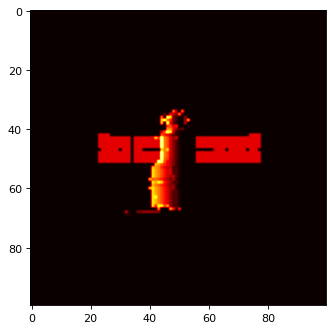

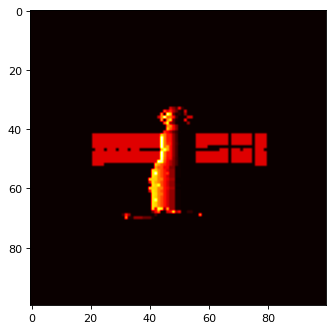

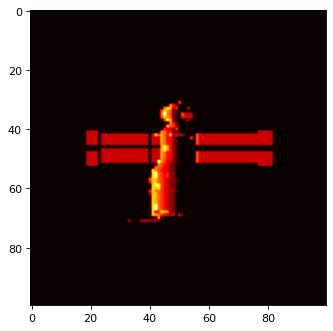

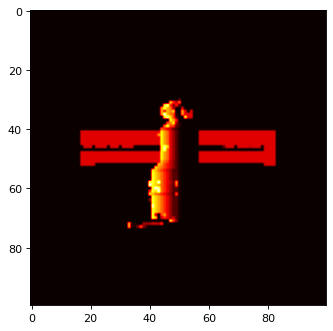

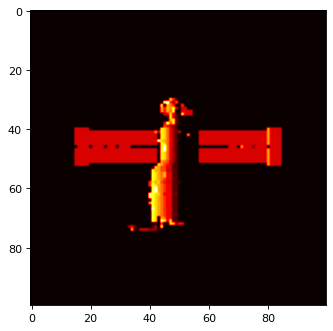

In [72]:
# 对模型进行occlusion culling
image = torch.zeros((Round_radar_los_real_all.shape[0],100,100),device=device)
image_phase = torch.zeros((Round_radar_los_real_all.shape[0],100,100),device=device)
# 雷达视线方向与转轴的夹角
theta_los_omega = torch.linalg.cross(Round_radar_los_all,omega_vec_all)
# 计算夹角的正弦值
sin_theta_los_omega = torch.linalg.norm(theta_los_omega,dim=-1)
# 多普勒距离维系数
lambda1 = torch.tensor([2.0],device=device)
dopplercoefficient = 2*omega/lambda1*sin_theta_los_omega
# 实例化occlusion culling和渲染器
visible_mesh1 = visible_mesh(device)
mesh_radar_render1 = mesh_radar_render(device)
# 由于直接进行并行运算显卡内存不够，因此分批次进行
plot_pointclouds_rotation(trg_mesh, "Source mesh")
# for i in range(0,Round_radar_los_real_all.shape[0],50):
step = 32
loop_num = 1
print("Shape of Round_radar_los_all[i:i+step]:", Round_radar_los_all[0:0+step].shape)

# 检查 trg_mesh 的形状
# print("Shape of trg_mesh:", trg_mesh.shape)
for i in range(0,loop_num*step,step):
    Meshes_new = visible_mesh1(trg_mesh,Round_radar_los_all[i:i+step])
    # plot_pointclouds_rotation(Meshes_new[0], "occlusion mesh")
    image[i:i+step,:,:]= mesh_radar_render1(Meshes_new,Round_radar_los_all[i:i+step],omega_vec_all[i:i+step],omega[i:i+step],dopplercoefficient[i:i+step])


image = torch.rot90(image,k=1,dims=(1,2))
image_phase = torch.rot90(image_phase,k=1,dims=(1,2))
# 显示成像后的图片
# plt.figure()
# plt.imshow(image[0,:,:].squeeze(0).detach().cpu(),cmap='hot')
# # # 将图片不带坐标轴的保存
# # plt.axis('off')
# # plt.savefig('image1.png',bbox_inches='tight',pad_inches=0)
# # plt.close()
plt.figure()
plt.imshow(image[3,:,:].squeeze(0).detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image[6,:,:].squeeze(0).detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image[9,:,:].squeeze(0).detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image[12,:,:].squeeze(0).detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image[15,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[6,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[9,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[12,:,:].squeeze(0).detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image[60,:,:].squeeze(0).detach().cpu(),cmap='hot')

# 显示成像后图片的相位
# plt.figure()
# plt.imshow(image_phase[0,:,:].squeeze(0).detach().cpu(),cmap='hot')


Power of image: tensor(0.0738, device='cuda:3')
Sigma: tensor([0.0280], device='cuda:3')


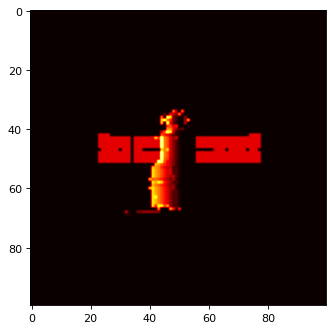

In [73]:
# 对成像后的图片增加噪声，噪声信噪比分别为-5dB,0dB,5dB,10dB,15dB,20dB
# 生成噪声
noise = torch.randn_like(image)
# 计算图片功率
power = torch.sum(image**2)/image.numel()
image_power = torch.max(image)
print("Power of image:", power)
# 信噪比
SNR = torch.tensor([20],device=device)
# 信噪比对应的噪声方差
sigma = torch.sqrt(image_power/(10**(SNR/10)))
print("Sigma:", sigma**2)
# 生成噪声
noise = noise * sigma.view(-1,1,1)
# 添加噪声
image_new = image

plt.figure()
plt.imshow(image_new[3,:,:].squeeze(0).detach().cpu(),cmap='hot')

In [74]:
# 将图片转换为numpy,并保存为png文件
image_max = image_new.max().detach().cpu().numpy()
# print(image_max)
image_min = image_new.min().detach().cpu().numpy()

# 存储生成的图片
import cv2
import numpy as np
filename = './wx/wangguanxing'
if not os.path.exists(filename):
    print("创建文件夹")
    os.makedirs(filename)
print(Round_radar_los_real_all.shape)
for i in range(0,Round_radar_los_real_all.shape[0]):
    image_i = image_new[i,:,:].squeeze(0).detach().cpu().numpy()
    image_i = (image_i - image_min)/(image_max-image_min)
    LOS_real = Round_radar_los_real_all[i].detach().cpu().numpy()
    rotation_axis = omega_vec_all[i].detach().cpu().numpy()
    print(image_i.max())
    print(image_i.min())
    np.savez(filename+'/image'+str(i)+".npz", image=image_i, LOS = LOS_real, rotation_axis = rotation_axis)
    image_i = np.uint8(image_i*255)
    cv2.imwrite(filename+'/image'+str(i)+".png",image_i)

创建文件夹
torch.Size([32, 3])
0.9702646
0.0
0.9218132
0.0
0.91976416
0.0
0.9174526
0.0
0.91487944
0.0
0.9186757
0.0
0.9089507
0.0
0.90559703
0.0
0.9683178
0.0
0.96720314
0.0
0.9359194
0.0
0.89314324
0.0
0.83135533
0.0
0.95250475
0.0
0.9668807
0.0
0.8175693
0.0
0.89485085
0.0
0.973777
0.0
0.9762349
0.0
0.9785298
0.0
0.9804314
0.0
0.98276657
0.0
0.9539677
0.0
0.9825864
0.0
0.9046738
0.0
0.9104481
0.0
0.9115961
0.0
0.955153
0.0
0.95916206
0.0
1.0
0.0
0.9488571
0.0
0.9522343
0.0
